In [18]:
from ast import literal_eval
from tcn_data_loader import TcnDataLoader
from tcn_model import DilatedNet
import configparser
from torch import nn
import torch
from torch.utils import data
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [2]:
config_location = '../ml_models_for_airflow/dbs3_config.ini'

In [3]:
config = configparser.ConfigParser()
config.read(config_location)

['../ml_models_for_airflow/dbs3_config.ini']

In [4]:
pairs_mapping = literal_eval(config['MODEL']['pairs_mapping'])
pairs = tuple(pairs_mapping.values())

In [5]:
features = ['askPrice', 'bidPrice', 'bidQty/askQty', 'volume', 'priceChangePercent']

In [6]:
SEQ_LENGTH = 110
BATCH_SIZE = 64
NUM_EPOCHS = 80
OPTIMIZER = 'ADAM'
LEARNING_RATE = 7.245336658547346e-05
GRAD_CLIPPING_VAL = 1
INIT_LR = 10
NUM_FEATURES = 5
OUT_CHANNELS = 6
DILATION = 4
DEPTH = 4

In [7]:
full_data_set = TcnDataLoader(
    config_location=config_location,
    pairs=pairs,
    seq_lenght=SEQ_LENGTH,
    features=features,
    local_path_book='book_data_tcn.csv',
    local_path_volume='volume_data_tcn.csv' 
    
)

In [8]:
# actual sequence length
SEQ_LENGTH = full_data_set.actual_sequence_length

In [9]:
train_set_size = int(len(full_data_set)*0.85)
test_set_size = len(full_data_set) - train_set_size

In [10]:
trainset, valset = data.random_split(full_data_set,
                                     [train_set_size, test_set_size]
                                    )

In [11]:
train_generator = data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_generator = data.DataLoader(valset, batch_size=len(valset), shuffle=True, num_workers=4)

In [12]:
model = DilatedNet(
    seq_length=SEQ_LENGTH,
    num_features=NUM_FEATURES,
    out_channels=2,
    dilation=3,
    depth=DEPTH,
    kernel_size=2
)

In [13]:
model.apply(model.init_weights)

DilatedNet(
  (relu): ReLU()
  (dilated_conv1): Conv1d(5, 2, kernel_size=(2,), stride=(1,), dilation=(3,))
  (convolution_blocks): Sequential(
    (0): Conv1d(2, 2, kernel_size=(2,), stride=(1,), dilation=(3,))
    (1): ReLU()
    (2): Conv1d(2, 2, kernel_size=(2,), stride=(1,), dilation=(3,))
    (3): ReLU()
    (4): Conv1d(2, 2, kernel_size=(2,), stride=(1,), dilation=(3,))
    (5): ReLU()
    (6): Conv1d(2, 2, kernel_size=(2,), stride=(1,), dilation=(3,))
    (7): ReLU()
  )
  (conv_final): Conv1d(2, 2, kernel_size=(1,), stride=(1,))
  (feed_forward): Linear(in_features=95, out_features=1, bias=True)
)

In [14]:
if OPTIMIZER == 'ADAM': optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
if OPTIMIZER == 'SGD': optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

learning_rate_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda i: min(i / (INIT_LR / BATCH_SIZE), 1.0))

In [15]:
criterion = torch.nn.BCELoss()
track_epoch_loss = []
train_auc = []
test_auc = []

In [16]:
for ep in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    temp_train_auc = 0
    
    for train_x, train_y in train_generator:
        
        predictions = model(train_x)
        loss = criterion(predictions, train_y.view(-1, 1))
        epoch_loss += loss.item()
        temp_train_auc += roc_auc_score(
            train_y.numpy(), predictions.detach().numpy())
        
        optimizer.zero_grad()
        loss.backward()
        
        # clip up
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIPPING_VAL)

        optimizer.step()
        learning_rate_scheduler.step()
    
    train_auc.append(temp_train_auc/len(train_generator))
    if ep % 10 == 0: print('train auc:', train_auc[-1], ' epoch:', ep)
    
    with torch.no_grad():
        model.eval()
        temp_test_auc = 0
        for test_x, test_y in test_generator:
            predictions = model(test_x)
            temp_test_auc += roc_auc_score(
                test_y.numpy(), predictions.numpy())

    test_auc.append(temp_test_auc/len(test_generator))
    if ep % 10 == 0: print('test auc:', test_auc[-1], ' epoch:', ep)

train auc: 0.4712447892353356  epoch: 0
test auc: 0.42795552530065806  epoch: 0
train auc: 0.4852082562160283  epoch: 10
test auc: 0.4315861130020422  epoch: 10
train auc: 0.5006488629061236  epoch: 20
test auc: 0.44134331744951216  epoch: 20
train auc: 0.47839732426773746  epoch: 30
test auc: 0.4245518493306104  epoch: 30
train auc: 0.48525635452258786  epoch: 40
test auc: 0.44157022918084865  epoch: 40
train auc: 0.49396024053067006  epoch: 50
test auc: 0.4236442024052644  epoch: 50
train auc: 0.48744073255449105  epoch: 60
test auc: 0.43045155434535964  epoch: 60
train auc: 0.4917623541594479  epoch: 70
test auc: 0.4379396414794645  epoch: 70


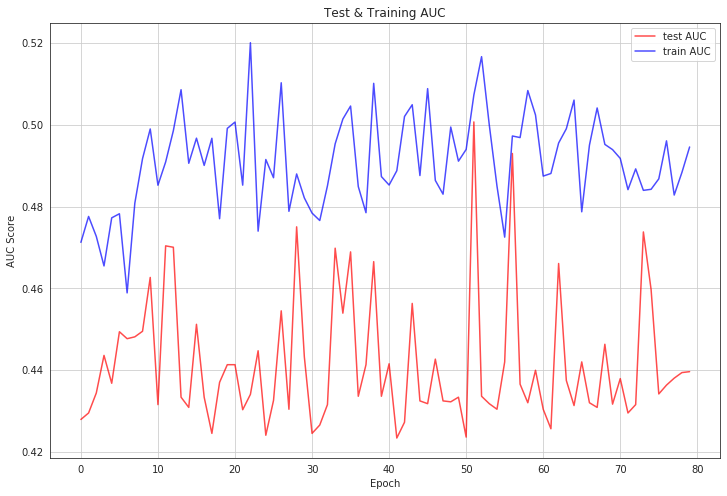

In [19]:
plt.figure(figsize=(12, 8))
plt.title('Test & Training AUC')
plt.plot(test_auc, label='test AUC', color='r', alpha=0.7)
plt.plot(train_auc, label='train AUC', color='b', alpha=0.7)
plt.ylabel('AUC Score')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()